# PC lab 6: Linear model selection - Regularization

We have already seen linear regression to tackle regression problems. With linear regression, we model a continous outcome as a linear function of the features:

\begin{equation}
\hat{y} = w_{0}x_{0} + w_{1}x_{1} + ... + w_{p}x_{p} = \sum\limits_{i=0}^{p}w_{i}x_{i}
\end{equation}

This works well when there are a lot of training observations and when the number of features (the dimensionality of the problem) is not too large. However, there are a couple of situations where ordinary linear regression might give problems:

* When the number of features $p$ becomes large with respect to the number of observations $n$, the variance of the model weights estimated by linear regression increases, which might result in poor predictive performance. Futhermore, there is no longer an analytical solution provided by least squares when $p > n$.
* It is possible that there are a lot of uninteresting or redundant features. If we want a sparse and interpretable model, we might want to do feature selection to reduce $p$.

In this lab, we will cover two solutions to the problems above: subset selection and regularization methods.

## Part 1: Subset selection methods

In subset selection, we only use a subset of the features that are available. The goal is to come up with a model that is sparse and that generalizes better to unseen data. There are two main strategies for subset selection: in *best subset selection*, we fit all the $p \choose k$ models for each $k = 1, 2.. p$ and retain the best model for each $k$. Finally, we select the model that performs best on some measure that controls for overfitting:

![bestsubset](https://raw.githubusercontent.com/gdewael/teaching/main/predmod/lab6/img/best_subset.png)

This becomes quickly unfeasible for large values of $p$. Therefore, an alternative approach is to perform *stepwise selection*, which explores a much smaller set of feature combinations. Stepwise selection can be performed either backward or forward. For large $p$ they are the only computationally feasible subset selection methods.

![forward](https://raw.githubusercontent.com/gdewael/teaching/main/predmod/lab6/img/forward.png)

Finally, it is important to account for the fact that the MSE (or, equivalently, the RSS) will always go down on the training data as we add more and more features. To select the best model out of several candidates, it is important to have an estimate of the test error of each model. This can be done indirectly by using a metric that penalizes for model complexity such as the AIC or the adjusted $R^2$. Another option is to use cross-validation to get an estimate of the test error.

**Let's apply subset selection on two datasets.** The first dataset contains features of mixtures used to produce concrete. The goal is to predict the compressive strength of the concrete.

In [1]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/BioML-UGent/MLLS/main/06_regularization/concreteComprStrength.txt", "concreteComprStrength.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/BioML-UGent/MLLS/main/06_regularization/fc_data_new.csv", "fc_data_new.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/BioML-UGent/MLLS/main/06_regularization/communities.csv", "communities.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/BioML-UGent/MLLS/main/06_regularization/meatNIR1000.csv", "meatNIR1000.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/BioML-UGent/MLLS/main/06_regularization/meatNIR1000.colnames", "meatNIR1000.colnames")

('meatNIR1000.colnames', <http.client.HTTPMessage at 0x7e7816313f80>)

In [2]:
# Read in the data
import pandas as pd

concretedata = pd.read_table('concreteComprStrength.txt', delim_whitespace=True, header=0, index_col=None)
print(concretedata.shape)
concretedata.head()

(1030, 9)


,cement,blastFurnaceSlag,flyAsh,water,superelastizer,coarseAggregate,fineAggregate,age,compressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Let's build up an intuition for the code we need for doing best subset selection with linear regression. We will implement algorithm 6.1 from the book as shown above. First we split the data and look at how we can generate all possible combinations of features:

In [3]:
X = concretedata.drop(['compressiveStrength'], axis=1)
y = concretedata['compressiveStrength']

from itertools import chain, combinations

list_of_things = [1, 2, 3]

for subset in chain.from_iterable(
    combinations(list_of_things, r)
    for r in range(1, len(list_of_things)+1)
    ):

    print(subset)

(1,)
(2,)
(3,)
(1, 2)
(1, 3)
(2, 3)
(1, 2, 3)


Now we can use this code to iterate not through `list_of_things` but through the possible features. For every subset we fit a model and keep it in a dictionary that records the score for that specific subset of features:

In [4]:
from sklearn.linear_model import LinearRegression

X = concretedata.drop(['compressiveStrength'], axis=1)
y = concretedata['compressiveStrength']

from itertools import chain, combinations

list_of_things = X.columns

scoring_dict = {}

for subset in chain.from_iterable(
    combinations(list_of_things, r)
    for r in range(1, len(list_of_things)+1)
    ):

    X_subset = X[list(subset)]

    model = LinearRegression()

    model.fit(X_subset, y)

    scoring_dict[subset] = model.score(X_subset, y)

Taking five random samples from this dict to get an idea what's in it:

In [5]:
import random
random.sample(list(scoring_dict.items()), 5)

[(('blastFurnaceSlag', 'flyAsh'), 0.022490072297912223),
 (('cement', 'coarseAggregate', 'fineAggregate', 'age'), 0.3458711803339152),
 (('water', 'coarseAggregate'), 0.13292467782241235),
 (('cement',
   'blastFurnaceSlag',
   'flyAsh',
   'water',
   'superelastizer',
   'fineAggregate',
   'age'),
  0.614123484277104),
 (('flyAsh', 'water', 'coarseAggregate', 'fineAggregate', 'age'),
  0.5275099384006545)]

Getting the best model:

In [6]:
max(scoring_dict, key=scoring_dict.get), scoring_dict[max(scoring_dict, key=scoring_dict.get)]

(('cement',
  'blastFurnaceSlag',
  'flyAsh',
  'water',
  'superelastizer',
  'coarseAggregate',
  'fineAggregate',
  'age'),
 0.6155198704142721)

We see that the best model (R² score-wise) is the one where all features are present. However, this is estimated on training data, so it might very well be that this is overfit. To do this in a better way, we will use cross-validation.
When doing this, it is important that for every model we train, we use exactly the same splits, otherwise, extra unwanted sources of variation are present in our model performance estimates. The following code block expands upon the previous code block with these things in mind: **This code may take a little while to run**

In [7]:
from sklearn.model_selection import KFold, cross_validate
import numpy as np


X = concretedata.drop(['compressiveStrength'], axis=1)
y = concretedata['compressiveStrength']
list_of_things = X.columns
scoring_dict = {}

#NEW:
# Define splitter object outside loop to ensure same splits over loop
splitter = KFold(n_splits=5, shuffle=True, random_state=None)
####

for subset in chain.from_iterable(
    combinations(list_of_things, r)
    for r in range(1, len(list_of_things)+1)
    ):

    X_subset = X[list(subset)]

    model = LinearRegression()

    # NEW: instead of simply fitting the model on all train data,
    # now we use cross validation to fit and evaluate model
    # cross_validate() returns a dict with key 'test_score' containing
    # a list of  CV performances of every split
    scores = cross_validate(model, X_subset.values, y.values, cv=splitter)
    scoring_dict[subset] = np.mean(scores['test_score'])

<div class="alert alert-success">
    <h2>Thought Exercise</h2>
    <p>how much models did we just train, exactly?</p>
</div>

Answer: (2^n_features - 1) * n_cv_folds

Let's visualize how the test performance changes in function of how many features we had in the model:

Best feature combination: ('cement', 'blastFurnaceSlag', 'flyAsh', 'water', 'fineAggregate', 'age')


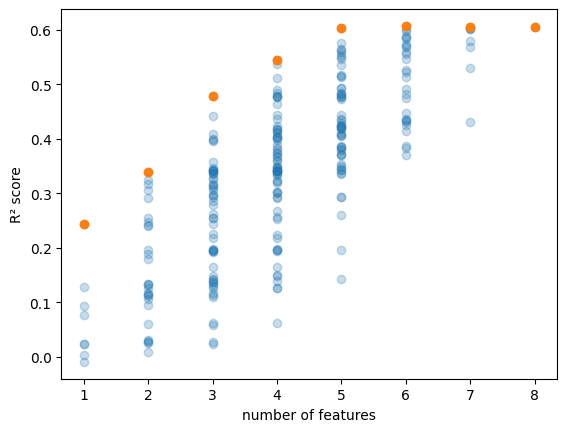

In [8]:
import matplotlib.pyplot as plt

plt.scatter([len(k) for k in scoring_dict.keys()], list(scoring_dict.values()), alpha = 0.25)
plt.xlabel('number of features')
plt.ylabel('R² score')
# taking the best model for every 'n' number of features and plotting them separately:
best_score_n = [
    max([v for k, v in scoring_dict.items() if len(k) == i])
    for i in range(1, X.shape[1]+1)
]
plt.scatter(range(1, X.shape[1]+1), best_score_n)
print('Best feature combination:', max(scoring_dict, key=scoring_dict.get))

We see that one certain combination of 5 features already results in a performance on +- the same level as the one with all features. This finding begs the question: could we have found this combination more efficiently, without testing out all possible feature combinations?
For example, we might have found it through *stepwise forward selection*. A code example is at the end of the PC lab

<div class="alert alert-success">
    <h2>Thought Exercise</h2>
    <p>Let's say we performed this feature selection method with k-nearest neighbor classifiers instead of logistic regression, and let's say we wanted to additionally tune the number of nearest neighbors we consider. How would you go about combining both feature selection and hyperparameter tuning?</p>
</div>

Answer: the feature set that is selected can also be seen as a hyperparameter. So in this case, we could run a tuning grid search testing every possible combination of: (1) n_neighbors, and (2) features included.

## Part 2: Regularization methods: ridge regression and the lasso


Instead of simplifying our model by choosing features, we can build it into our model with **regularization**. Regularization is one of the most important concepts in machine learning to avoid overfitting. It comes in many forms. In linear regression, regularization techniques typically constrain the coefficient estimates. In return for a little extra bias, this reduces the variance of the coefficient esimates. The two main shrinkage techniques are **ridge regression** and the **lasso**.

**Ridge regression penalizes the sum of the squares of the model weights by adding a term to the MSE loss function**:

$$\hat{\mathbf{w}} = \text{argmin}_\mathbf{w} \sum^n_{i=1} \left(y_i - \sum^p_{j=0}w_j x_{ij} \right)^2 + \lambda \sum_{j=1}^p w_j^2$$

The lasso does a similar thing, but penalizes the absolute value of the model coefficients. The effect of both approaches is that the model coefficients are shrunk towards zero, resulting in less overfitting and less variance in the predictions (at the cost of a little more bias). We will apply both models on two datasets.

Note that we shown the equation for regularization pentalties here for linear regression with MSE loss, but the technique is equally applicable to classification loss functions (e.g. cross entropy)

### Ridge for high dimensional data

We will apply ridge regression on the Communities and Crime Data Set. The dataset contains 123 population statistics on 1994 communities. We would like to predict the number of violent crimes per 100000 inhabitants. This is the final column of the dataframe. Of the 123 features, a lot contain missing values, so we will drop these columns and use only 99 features.

In [9]:
import pandas as pd
import numpy as np

data = pd.read_csv('./communities.csv')

# Drop columns with missing values
data = data.dropna(axis=1)
print(data.shape)
data.head()

(1994, 100)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Use linear regression and ridge regression to predict the number of violent crimes per 100,000 inhabitants. Use 5-fold cross-validation to evaluate both models. The scikit-learn implementation of RidgeCV automatically performs cross-validation to tune the hyperparameter that determines the amount of regularization, so you don't need to implement a second cross-validation loop. Which model performs best?</p>
</div>

**Before we apply ridge regression, it's important to make sure that all the features are on the same scale. If one of the features is on a completely different scale (let's say, income can be measured in dollars or in thousands of dollars), this might lead the ridge regression coefficient to change substantially because of the penalty term in the optimization problem. We can make sure that all the features are on the same scale by use of the standard scaling: (see book p. 232)**

\begin{equation}
\tilde{x}_{ij} = \frac{x_{ij}-\bar{x}_{j}}{\sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_{ij} - \bar{x}_{j})^2}}
\end{equation}

We can do this with the ```StandardScaler``` from scikit-learn. We will do the scaling each time in the cross-validation loop using only training data statistics (*think for yourselves: do you still remember why we only use training statistics to do this?*).

In [10]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [11]:
# ** solution

# Select X and y
y = data['ViolentCrimesPerPop'].values
X = data.drop(['ViolentCrimesPerPop'], axis=1).values

kf = KFold(n_splits=5)

linreg_scores = []
ridge_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    linregmodel = LinearRegression()
    ridgemodel = RidgeCV(alphas=np.logspace(-3,3,100))

    linregmodel.fit(X_train, y_train)
    linreg_scores.append(linregmodel.score(X_test,y_test))

    ridgemodel.fit(X_train, y_train)
    print('Regularization parameter: {}'.format(ridgemodel.alpha_))
    ridge_scores.append(ridgemodel.score(X_test,y_test))


print('Average validation fold R² of linear regression: {}'.format(np.mean(linreg_scores)))
print('Average validation fold R² of ridge regression: {}'.format(np.mean(ridge_scores)))

# ** solution

Regularization parameter: 26.560877829466893
Regularization parameter: 35.111917342151344
Regularization parameter: 40.37017258596558
Regularization parameter: 53.366992312063125
Regularization parameter: 26.560877829466893
Average validation fold R² of linear regression: 0.6476679415961166
Average validation fold R² of ridge regression: 0.6556882222065491



Finally, it's interesting to look at how the amount of regularization in ridge regression and lasso regression affects the magnitudes of the fitted weights.

In [12]:
from sklearn.linear_model import Ridge, Lasso
from matplotlib import pyplot as plt
%matplotlib inline

y = data['ViolentCrimesPerPop'].values
X = data.drop(['ViolentCrimesPerPop'], axis=1).values

# Scale X, note the "wrong" way in which we do it here. This code is only to make a nice plot!
scaler = StandardScaler()
x = scaler.fit_transform(X)
x = X
alphas = np.logspace(-5,2,100)

ridge_coefficients = np.ndarray(shape=(50, len(alphas)))
lasso_coefficients = np.ndarray(shape=(50, len(alphas)))

for i,a in enumerate(alphas):
    ridgemodel = Ridge(alpha=a)
    lassomodel = Lasso(alpha=a, max_iter=10000)

    ridgemodel.fit(X,y)
    lassomodel.fit(X,y)

    ridge_coefficients[:, i] = ridgemodel.coef_[:50]
    lasso_coefficients[:, i] = lassomodel.coef_[:50]

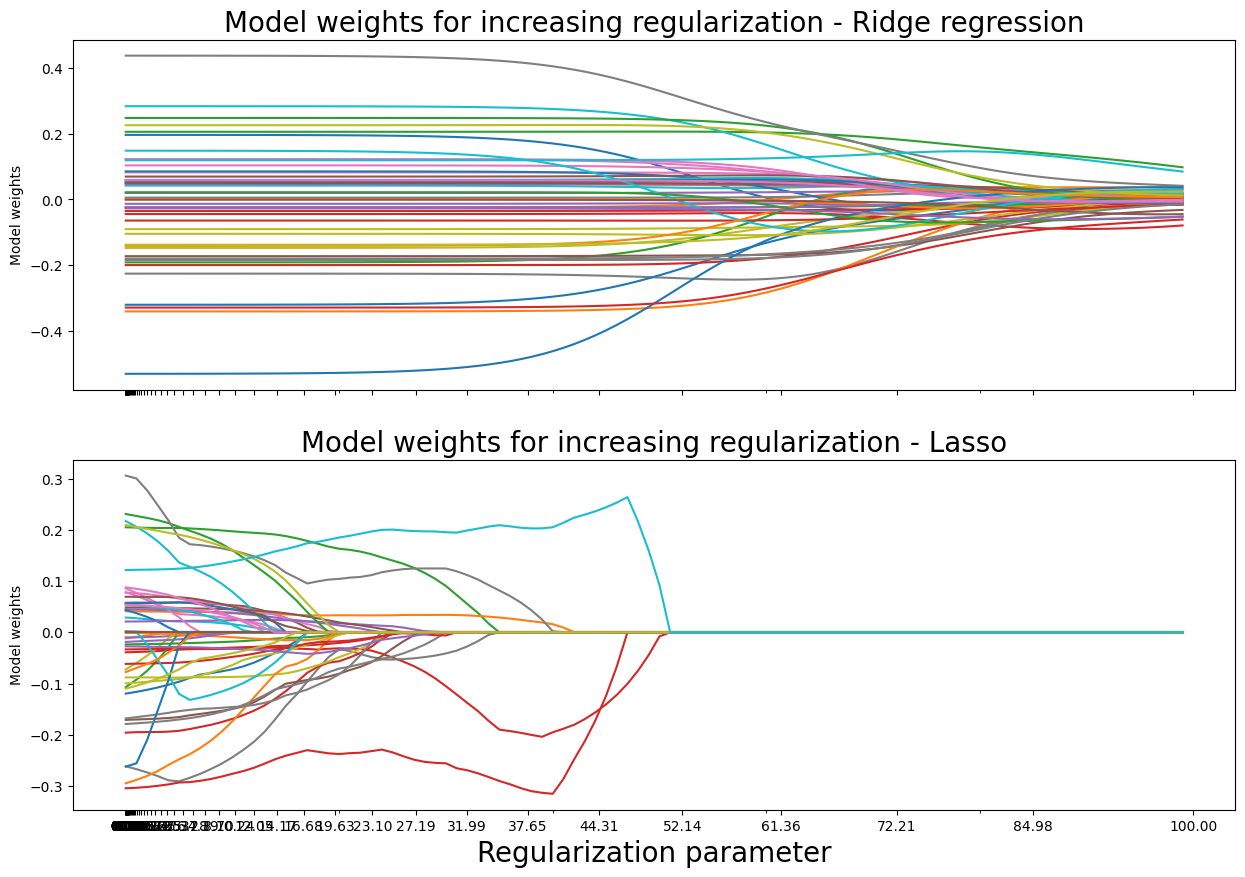

In [13]:
fig, ((ax1, ax2)) = plt.subplots(figsize=(15,10), nrows=2, sharex=True)

for c in range(ridge_coefficients.shape[0]):
    pd.Series(ridge_coefficients[c,:]).plot(ax=ax1)
    pd.Series(lasso_coefficients[c,:]).plot(ax=ax2)

ax2.set_xlabel('Regularization parameter').set_fontsize(20)
ax1.set_ylabel('Model weights')
ax2.set_ylabel('Model weights')
ax1.set_title('Model weights for increasing regularization - Ridge regression').set_fontsize(20)
ax2.set_title('Model weights for increasing regularization - Lasso').set_fontsize(20)
ax2.get_xaxis().set_ticks(alphas);

<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Make sure you understand the plots above. What is the main difference between ridge regression and the lasso?
    </p>
</div>

### Feature selection with the lasso

Suppose that we are interested in selecting only a couple of features out of a high dimensional dataset. Let's fit ridge regression and lasso regression on the data and look at the model coefficients for both models:

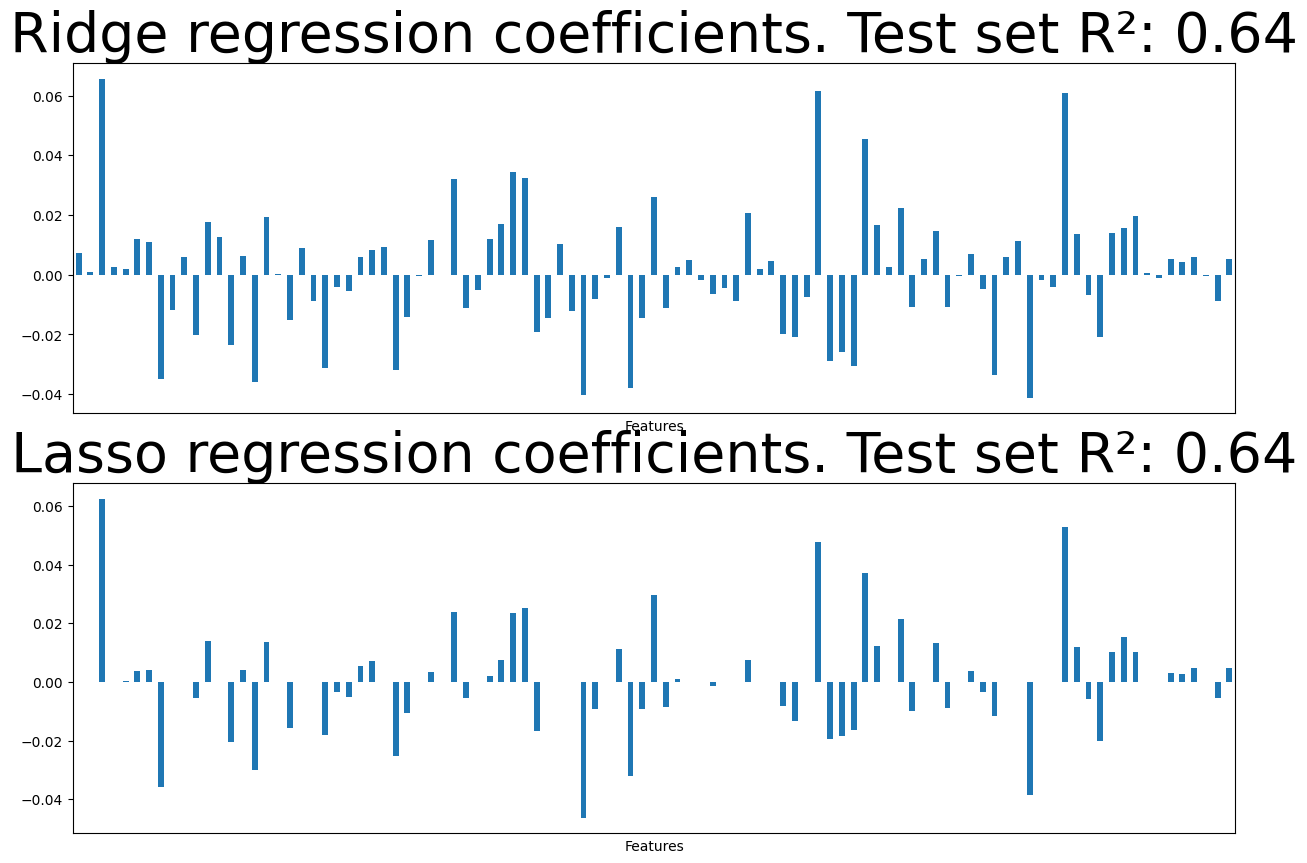

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

ridgemodel = RidgeCV(cv=5)
lassomodel = LassoCV(cv=5, max_iter=10000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale X
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ridgemodel.fit(X_train, y_train)
ridgescore = np.round(ridgemodel.score(X_test, y_test),2)
lassomodel.fit(X_train, y_train)
lassoscore = np.round(lassomodel.score(X_test, y_test),2)

# Plot of the coefficients for ridge regression
fig, ((ax1, ax2)) = plt.subplots(figsize=(15, 10), nrows=2)
pd.Series(ridgemodel.coef_).plot(kind='bar', ax=ax1)
ax1.set_title('Ridge regression coefficients. Test set R²: {}'.format(ridgescore)).set_fontsize(40)
ax1.get_xaxis().set_ticks([])
ax1.set_xlabel('Features')

# Plot of the coefficients for the lasso
pd.Series(lassomodel.coef_).plot(kind='bar', ax=ax2)
ax2.set_title('Lasso regression coefficients. Test set R²: {}'.format(lassoscore)).set_fontsize(40)
ax2.get_xaxis().set_ticks([])
ax2.set_xlabel('Features');

The lasso applies regularization by constraining the sum of the absolute values of the model coefficients (the L1-norm). A result of this is that a lot of model coefficients are set to zero: the lasso performs **feature selection**. This is not the case for ridge regression: the model weights are rarely set to zero. Feature selection is a nice property if we want an interpretable model. Let's list the features with non-zero coefficients in the lasso:

/tmp/ipykernel_154456/1804031685.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= pd.Series(lassomodel.coef_[lassomodel.coef_ != 0]),


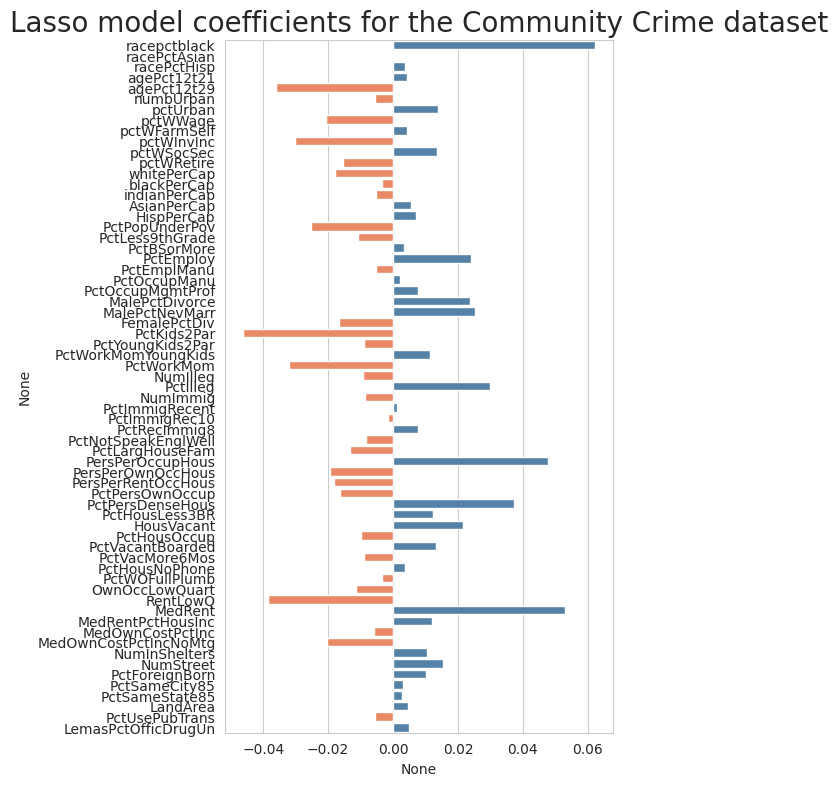

In [15]:
import seaborn as sns
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(5,9))
sns.barplot(x= pd.Series(lassomodel.coef_[lassomodel.coef_ != 0]),
            y=data.drop(['ViolentCrimesPerPop'], axis=1).columns[lassomodel.coef_ != 0],
            palette=['steelblue' if n > 0 else 'coral' for n in lassomodel.coef_[lassomodel.coef_ != 0]],
            ax=ax);
ax.set_title('Lasso model coefficients for the Community Crime dataset').set_fontsize(20);

#### Extra note: **machine learning bias**

Take a look at which features our model has identified as important for predicting whether a community will have a higher percentage of crime. You will perhaps be shocked (or unsurprised) to find that our model has quite a racial bias.

It is prudent to keep in mind that ML models - no matter how complicated they get - will only ever learn the **correlations** in the given **data**. There may be issues with the data, or there may be issues with the fact that the correlations do not imply causation. In any case, a good data scientist will keep this in mind when interpreting their models.


For example, in this case: socio-economical factors for crime rates will be correlated with all of the features. Is our feature set sufficient to control for this? Even more, if everything correlates with everything - we may question the validity of weights altogether. The next section explains why.

### On multicollinearity, regularization, and interpretability

Consider the following dummy example with 2 perfectly-correlated features, 3 samples, and a desired output that is always 0:

<img src=https://raw.githubusercontent.com/BioML-UGent/MLLS/refs/heads/main/06_regularization/regularization.png>


Because the features are perfectly correlated, when we try to find suitable model weights, all weights satisfying $w_1 = -2 w_2$ will result in a zero loss.

This results in two issues:
- Difficult optimization: Because the loss landscape is elongated along the diagonal, gradient descent may "bounce" around the "valley".
- Uninterpretable weights: the model can equally assign either a positive or a negative weight to a feature by counterbalancing the other feature weight. It is hence impossible to ascertain whether a feature has a positive or negative effect.

Regularization will help alleviate these issues somewhat by enforcing weights to be small.

**To illustrate**, suppose we use the same dataset, but instead of having 99 features, we have four times as many. And suppose that a lot of those features are heavily correlated. This situation is very common in lots of datasets. We will mimic this situation by adding correlated features to our original feature matrix:

In [16]:
import pandas as pd
import numpy as np

data = pd.read_csv('./communities.csv')
data = data.dropna(axis=1)
y = data['ViolentCrimesPerPop'].values
X = data.drop(['ViolentCrimesPerPop'], axis=1).values

# copy the feature set X multiple times with some added noise and append as extra features
X_1 = X + np.random.normal(loc=0, scale=0.05, size=(X.shape))
X_2 = X + np.random.normal(loc=0, scale=0.1, size=(X.shape))
X_3 = X + np.random.normal(loc=0, scale=0.01, size=(X.shape))
X_expanded = np.concatenate((X, X_1, X_2, X_3), axis=1)

X_expanded.shape

(1994, 396)

<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Repeat the comparison between ridge regression and linear regression from above, but with the new feature matrix that contains correlated features. What happens with the performance of linear regression? What happens with the regularization parameter? Now, add even more correlated features and repeat the analysis.</p>
</div>

In [17]:
# ** solution

kf = KFold(n_splits=5)

linreg_scores = []
ridge_scores = []

for train_index, test_index in kf.split(X_expanded):
    X_train, X_test = X_expanded[train_index], X_expanded[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    linregmodel = LinearRegression()
    ridgemodel = RidgeCV(alphas=np.logspace(-4,4,100))

    linregmodel.fit(X_train, y_train)
    linreg_scores.append(linregmodel.score(X_test,y_test))

    ridgemodel.fit(X_train, y_train)
    print('Regularization parameter: {}'.format(ridgemodel.alpha_))
    ridge_scores.append(ridgemodel.score(X_test,y_test))


print('Average validation fold R² of linear regression: {}'.format(np.mean(linreg_scores)))
print('Average validation fold R² of ridge regression: {}'.format(np.mean(ridge_scores)))
# ** solution

Regularization parameter: 739.072203352579
Regularization parameter: 890.2150854450392
Regularization parameter: 890.2150854450392
Regularization parameter: 1072.2672220103254
Regularization parameter: 739.072203352579
Average validation fold R² of linear regression: 0.566688368635806
Average validation fold R² of ridge regression: 0.6505933365556084


## Extra part 1: Regularization methods for $n < p$ data

In high dimensional data, we often have more features than observations. This is often called the $n < p$ scenario. In this situation, linear regression breaks down: the variance on the weight estimates blows up and the model will fail on unseen data. Both ridge regression and the lasso are valuable solutions here.

We will work with a dataset that contains spectral measurements on food samples. The target variables are the water, fat and protein content of the samples.

In [18]:
# Read in the data
data = pd.read_csv('./meatNIR1000.csv', header=None)
colnames = pd.read_csv('./meatNIR1000.colnames', header=None)
data.columns = colnames.values[0]
W = data['water']
F = data['fat']
P = data['protein']

data = data.drop(['water', 'fat', 'protein'], axis=1)
print(data.shape)
data.head()

(240, 500)


,852.000000,852.396794,852.793587,853.190381,853.587174,853.983968,854.380762,854.777555,855.174349,855.571142,...,1046.428858,1046.825651,1047.222445,1047.619238,1048.016032,1048.412826,1048.809619,1049.206413,1049.603206,1050.000000
0,2.61776,2.617830,2.617903,2.617978,2.618056,2.618137,2.618220,2.618307,2.618396,2.618488,...,2.855280,2.851276,2.847266,2.843252,2.839238,2.835224,2.831212,2.827203,2.823199,2.81920
1,2.83454,2.835379,2.836211,2.837037,2.837859,2.838677,2.839493,2.840308,2.841123,2.841941,...,3.208502,3.205398,3.202256,3.199079,3.195870,3.192631,3.189364,3.186072,3.182757,3.17942
2,2.58284,2.583193,2.583542,2.583886,2.584227,2.584566,2.584904,2.585241,2.585579,2.585919,...,2.576803,2.573551,2.570320,2.567107,2.563911,2.560732,2.557568,2.554419,2.551283,2.54816
3,2.82286,2.823218,2.823569,2.823913,2.824252,2.824587,2.824919,2.825252,2.825587,2.825926,...,2.832259,2.828159,2.824084,2.820034,2.816008,2.812005,2.808026,2.804069,2.800134,2.79622
4,2.78813,2.788479,2.788828,2.789177,2.789526,2.789876,2.790226,2.790577,2.790930,2.791284,...,3.173418,3.169454,3.165488,3.161516,3.157539,3.153555,3.149563,3.145563,3.141552,3.13753


We have 240 observations, but 500 features, so we are in a $n < p$ setting:

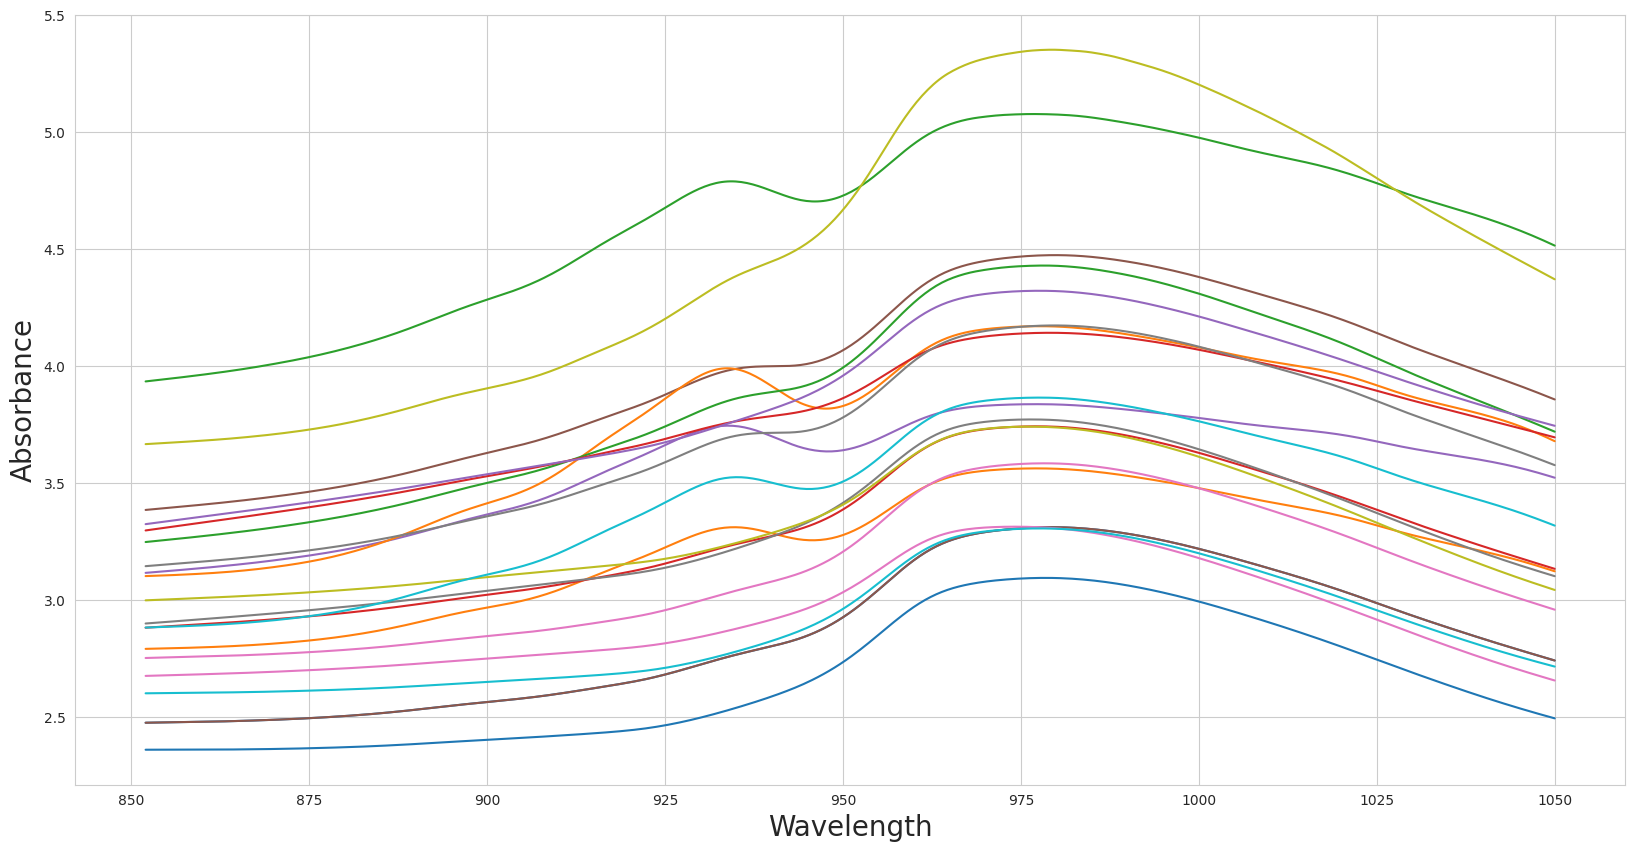

In [19]:
# let's plot some random data points

fig, ax = plt.subplots(figsize=(20,10))
for i in range(20):
    ax.plot(data.iloc[np.random.choice(range(len(data)))])
ax.set_xlabel('Wavelength').set_fontsize(20)
ax.set_ylabel('Absorbance').set_fontsize(20)

<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Try to fit a linear regression model to predict the fat content of a sample on the entire dataset (don't bother with cross validation / splitting / scaling, just fit a model). Look at the model coefficients (look up documentation to see how to) What happens?
    </p>
</div>

In [20]:
# ** solution
from sklearn.linear_model import LinearRegression
X = data.values
y = F
model = LinearRegression()

model.fit(X, y)
model.coef_[:20]
# ** solution

array([-8.27311582e+12,  2.49187879e+13, -1.74487900e+13, -3.89745183e+12,
        1.67756160e+11,  9.82477441e+12, -2.12173733e+13,  1.60206871e+13,
        6.38923871e+12,  6.65283115e+12, -1.06393356e+13, -6.85662409e+12,
        1.16114583e+12, -1.14020914e+13,  3.24323760e+13, -1.60903526e+13,
       -4.84039381e+12, -1.61007221e+13,  2.24588404e+13,  1.06682574e+12])

<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Compare the performance of linear regression with ridge regression and with the lasso. Use 5-fold cross-validation to evaluate both models.</p>
</div>

In [21]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LassoCV, RidgeCV
# Select X and y
y = F
X = data.values

kf = KFold(n_splits=5)

linreg_scores = []
ridge_scores = []
lasso_scores = []

for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    scaler = StandardScaler()
    # note that standardscaling probably only has a small or no effect here:
    # the data already is on the same scale (see the plot with the wavelengths above)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


    # Instantiate Linear Regression
    # Instantiate RidgeCV
    # Instantiate LassoCV
    linregmodel = LinearRegression()
    ridgemodel = RidgeCV(alphas=np.logspace(-2,4,10))
    lassomodel = LassoCV(alphas=np.logspace(-2,4,10))


    # Fit all three models
    linregmodel.fit(X_train, y_train)
    ridgemodel.fit(X_train, y_train)
    lassomodel.fit(X_train, y_train)

    # Append scores
    linreg_scores.append(linregmodel.score(X_test,y_test))
    ridge_scores.append(ridgemodel.score(X_test,y_test))
    lasso_scores.append(lassomodel.score(X_test,y_test))

print('Average validation fold R² of linear regression: {}'.format(np.mean(linreg_scores)))
print('Average validation fold R² of ridge regression: {}'.format(np.mean(ridge_scores)))
print('Average validation fold R² of lasso regression: {}'.format(np.mean(lasso_scores)))

Average validation fold R² of linear regression: 0.5796018195789228
Average validation fold R² of ridge regression: 0.8892450136620111
Average validation fold R² of lasso regression: 0.6807659819186395


## Extra part 2: Stepwise forward selection

This piece of code is here for reference purposes, so that you have a working implementation.

We will use a different dataset. This time, the features are measurements from a flow cytometry experiment. The 'SC' features measure scatter, and say something about the morphologhy of the cells (FSC: forwad scatter, SSC: sideway scatter). The 'FL' features are fluorescence features from different parts of the spectrum. There are two possible bacterial species present in the dataset. The goal is to classify the correct species based on the measurements from the flow cytometer. Species number one corresponds to *Pseudomonas putida*, while species number 6 is *Brachybacterium faecium*. We will use logistic regression to do the classification.

This dataset has 10 features instead of the 8 features encountered in the previous dataset. This makes the number of possible combinations (power set): $(2^{10} -1 ) \cdot n_{folds} = 5115$, instead of $(2^{8} -1) \cdot n_{folds} = 1275$. We could repeat the same *best subset selection* method, but we will be smarter about it and implement *stepwise forward selection*.

In [22]:
# Read in the data
bacterialdata = pd.read_csv('fc_data_new.csv', index_col=0)
bacterialdata = bacterialdata.drop(['Width', 'Time'], axis=1).reset_index(drop=True)

bacterialdata.head()

,FSC-A,SSC-A,FL1-A,FL2-A,FL3-A,FL4-A,FSC-H,SSC-H,FL1-H,FL2-H,species
0,47325.0,11730.0,311772.0,70873.0,70379.0,0.0,55410.0,13649.0,208324.0,47062.0,6
1,15766.0,4417.0,285761.0,64624.0,50408.0,0.0,36950.0,8129.0,238931.0,52847.0,6
2,11206.0,3194.0,403584.0,96978.0,73632.0,18.0,33761.0,4810.0,358999.0,86278.0,6
3,33577.0,5558.0,258064.0,52010.0,35322.0,0.0,72014.0,10396.0,226185.0,44847.0,1
4,5525.0,2417.0,348457.0,64062.0,33637.0,1525.0,19074.0,5938.0,304335.0,55864.0,6


<div class="alert alert-success">
    <h2>Thought Exercise</h2>
    <p>Considering we have 10 features and will use 5-fold cross validation: how much models will we train using stepwise forward selection?</p>
</div>

<div class="alert alert-success">
    <h2>Exercise</h2>
    <p>Complete the code below to implement stepwise forward selection:</p>
</div>

Text(0, 0.5, 'accuracy')

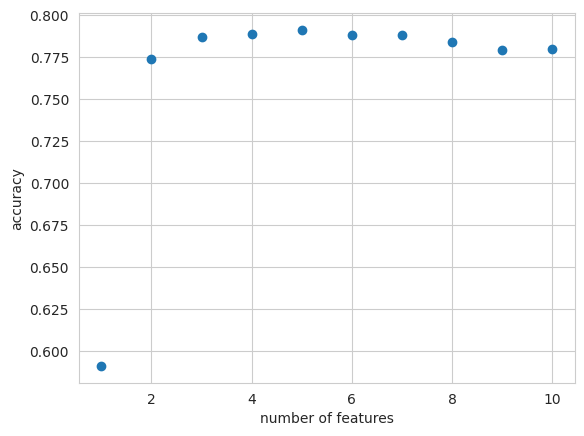

In [25]:
from sklearn.linear_model import LogisticRegression

X = bacterialdata.drop(['species'], axis=1)
y = bacterialdata['species']
list_of_things = X.columns
scoring_dict = {}

splitter = KFold(n_splits=5, shuffle=True, random_state=None)


features_already_in_model = set()
features_not_in_model = set(X.columns)

# iterate through the numbers of features that we can add at every step
for k in np.arange(1, X.shape[1] + 1):
    # at every step: iterate through the features that we can still add
    # keep a separate scoring dictionary for features added at this step:
    scoring_dict_k = {}
    for feature in features_not_in_model:
        # select the previously added features + a feature to (maybe) add
        X_subset = X[list(features_already_in_model) + [feature]]

        model = LogisticRegression(max_iter = 1000)

        scores = cross_validate(model, X_subset.values, y.values, cv=splitter)
        
        scoring_dict_k[feature] = np.mean(scores['test_score'])

    feature_to_add = max(scoring_dict_k, key=scoring_dict_k.get)
    features_already_in_model.add(feature_to_add)
    features_not_in_model.remove(feature_to_add)
    scoring_dict[tuple(features_already_in_model)] = max(scoring_dict_k.values())

import matplotlib.pyplot as plt

plt.scatter([len(k) for k in scoring_dict.keys()], list(scoring_dict.values()))
plt.xlabel('number of features')
plt.ylabel('accuracy')

In [26]:
for k, v in scoring_dict.items():
    print(k, v)

('FSC-A',) 0.591
('FL3-A', 'FSC-A') 0.7737499999999999
('FL1-A', 'FL3-A', 'FSC-A') 0.7870000000000001
('FL1-A', 'FL3-A', 'FL2-H', 'FSC-A') 0.7889999999999999
('FL1-A', 'FSC-A', 'FL2-H', 'FL2-A', 'FL3-A') 0.79125
('FL1-A', 'SSC-A', 'FSC-A', 'FL2-H', 'FL2-A', 'FL3-A') 0.7885
('FL1-A', 'SSC-A', 'FSC-A', 'FL2-H', 'FL2-A', 'SSC-H', 'FL3-A') 0.7885000000000001
('FL1-A', 'SSC-A', 'FSC-A', 'FL4-A', 'FL2-H', 'FL2-A', 'SSC-H', 'FL3-A') 0.784
('FL1-H', 'FL1-A', 'SSC-A', 'FSC-A', 'FL4-A', 'FL2-H', 'FL2-A', 'SSC-H', 'FL3-A') 0.77925
('FL1-H', 'FL1-A', 'SSC-A', 'FSC-A', 'FL4-A', 'FSC-H', 'FL2-H', 'FL2-A', 'SSC-H', 'FL3-A') 0.7797499999999999
